# Create a Georeferenced Dataset in xarray

## Introduction

This notebook provides a more detailed explanation of the steps, described in [working_with_smap_in_xarray](working_with_smap_in_xarray.ipynb), that are required to create a georeferenced `xarray.Dataset` from SMAP SPL3SMP data.

## Why create a georeferenced dataset

Georeferenced data sets are a keystone for Earth science analysis workflows.  If your data is not georeferenced, it cannot be tied to a location on Earth.  

Your analysis may be as simple as plotting a map.  You may want to transform the data so it can be used with another data set, or you may want to perform some spatial subsetting.  Each of these tasks requires that the coordinate system of the dataset is known and that there is sufficient information to relate the coordinate system to an actual location on the Earth.  The coordinate system may be a Geodetic coordinate system (e.g. _latitude_ and _longitude_) or a projected coordinated system with cartesian coordinates (e.g. _x_ and _y_).  The coordinate system may also include a _height_ component (sometimes _z_ or atmospheric _level_).  Other non-geospatial dimensions, such as _time_ may also be included.  

The relationship between the coordinate system and a location on the Earth is defined by a coordinate reference system (CRS), sometimes called a spatial reference system (SRS).  This includes a reference ellipsoid and datum, and, if the data are in a projected coordinate system, information about the projection method and projection parameters.  Ideally, this information is included in the data file, following a standard convention, so that software tools can interpret this information directly. Including this information in files also makes it very easy for users to understand the data.

## An introduction to xarray

[`xarray`](https://docs.xarray.dev/en/latest/getting-started-guide/why-xarray.html) is one of the most popular tools for working with multi-dimensional geoscience data.  It uses a data model based on the netCDF file format and CF-Conventions commonly used in the geosciences.  This data model has the concepts of _dimensions_ and _coordinates_ that are associated with each variable.  Dimensions are the axes of n-dimensional data arrays.  In geoscience, these are commonly spatial dimensions such as latitude, longitude, x, y, height, as well as time.  Dimensions are associated with coordinates that map arrays values to locations in space and time.

There are many advantages to having well-named dimensions along with coordinates.  A key advantage is that code is easier to understand for a _future-you_ and for others users, and it is likely to be less error-prone.  Another important advantage is that it allows access to the powerful analysis features of `xarray`, as well as other software tools.

## Why we need to fix SMAP data

The SMAP HDF5 data files do not have named dimensions.  Nor do they contain sufficient information to geolocate data on the Earth surface.  Fortunately, this is easy to fix.  In the following sections we will:

1. add meaningful dimension names;
2. mask missing data;
3. add coordinate information to the dataset;
4. add a coordinate reference system information the dataset.

## Import libraries

In [1]:
from pathlib import Path  # for working with paths on the local file system
from pprint import pprint  # for nice printing

# For data search and download
import earthaccess

# For reading and working with the data
# import rioxarray
import xarray as xr
import rioxarray
import numpy as np

# For defining CRS and image coordinate system
from affine import Affine
from pyproj import CRS

# For plotting
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

/home/apbarret/mambaforge/envs/nsidc-tutorials-dev/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Download data

We'll use the same data as in [working_with_smap_in_xarray](notebooks/SMAP/working_with_smap_in_xarray.ipynb).  Even if you have already run that notebook, still run the cell below.  `earthaccess.download` checks if files exist locally and does not download them again.

In [2]:
auth = earthaccess.login()

results = earthaccess.search_data(
    short_name = 'SPL3SMP',
    version = '009',
    cloud_hosted = True,
    temporal = ('2017-03-01','2017-03-31')
)

smap_files = earthaccess.download(results, local_path="smap_data")

QUEUEING TASKS | : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 5414.48it/s]
PROCESSING TASKS | : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 150490.07it/s]
COLLECTING RESULTS | : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 341268.83it/s]


## Load data

As with [working_with_smap_in_xarray](notebooks/SMAP/working_with_smap_in_xarray.ipynb), we will load data for the `Soil_Moisture_Retrieval_Data_AM` group using `xarray`.

In [3]:
gds = xr.open_dataset(smap_files[0], group='Soil_Moisture_Retrieval_Data_AM', 
                      phony_dims='sort', engine="h5netcdf", decode_coords="all",
                      decode_timedelta=True)
gds

<xarray.Dataset> Size: 99MB
Dimensions:                      (phony_dim_0: 406, phony_dim_1: 964,
                                  phony_dim_2: 3)
Dimensions without coordinates: phony_dim_0, phony_dim_1, phony_dim_2
Data variables: (12/53)
    EASE_column_index            (phony_dim_0, phony_dim_1) float32 2MB ...
    EASE_row_index               (phony_dim_0, phony_dim_1) float32 2MB ...
    albedo                       (phony_dim_0, phony_dim_1) float32 2MB ...
    albedo_dca                   (phony_dim_0, phony_dim_1) float32 2MB ...
    albedo_scah                  (phony_dim_0, phony_dim_1) float32 2MB ...
    albedo_scav                  (phony_dim_0, phony_dim_1) float32 2MB ...
    ...                           ...
    tb_v_uncorrected             (phony_dim_0, phony_dim_1) float32 2MB ...
    vegetation_opacity           (phony_dim_0, phony_dim_1) float32 2MB ...
    vegetation_opacity_dca       (phony_dim_0, phony_dim_1) float32 2MB ...
    vegetation_opacity_scah      (phony_dim_0, phony_dim_1) float32 2MB ...
    vegetation_opacity_scav      (phony_dim_0, phony_dim_1) float32 2MB ...
    vegetation_water_content     (phony_dim_0, phony_dim_1) float32 2MB ...

## Rename dimension names

53 variables are loaded from `Soil_Moisture_Retrieval_Data_AM`.  However, we can immediately see some issues.  The dimensions are named `phony_dim_0`, `phony_dim_1`, and `phony_dim_2`, which is not much help.  This is because no dimensions are assigned to Datasets, so `xarray` has to generate some dummy variables.
 
We'll change the names of the dimensions to something meaningful.  First, we need figure out what the dimensions are.  This is more diffcult than it should be and requires some data sleuthing and assumptions.  The description of the `landcover_class` offers some information, albeit misleading, but it is a clue.

> An enumerated type that specifies the most common landcover class in the grid cell based on the IGBP landcover map. The array order is longitude (ascending), followed by latitude (descending), and followed by IGBP land cover type descending dominance (only the first three types are listed)

This description states that the dimensions of the landcover_class array are longitude, latitude and IGBP land cover class.  The data are in projected coordinates (the EASE Grid 2.0 Global) **so longitude and latitude cannot be dimensions**.  Longitude and latitude in projected coordinate systems must be 2D arrays.  For projected coordinate systems, coordnates are usually x and y, or easting and northing.  From the user guide, we also know that the data are on a grid with 964 columns and 406 rows, and cells that have a nominal cell-size of 36 km by 36 km.  Based on this information we can assume that `phony_dim_0` is the y-dimension and `phony_dim_1` is the x-dimension in cartesian coordinates.  The 3rd dimension (`phoney_dim_2`) appears to be land cover class.  We can plot the data to confirm that this at least looks correct.  

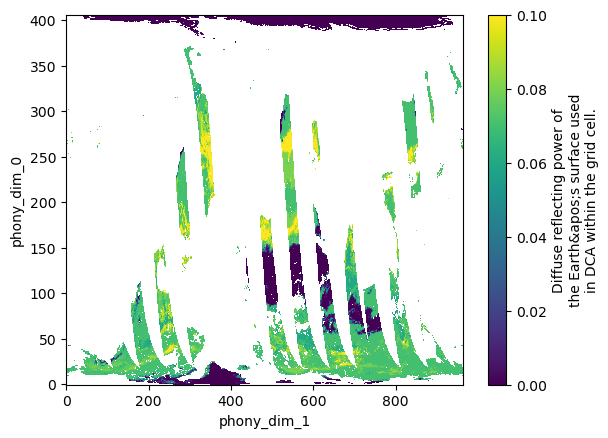

In [4]:
gds.albedo.plot()

Apart from looking like the data is upside down, our assumptions about `x` and `y` look to be correct.  So we'll rename the coordinates:

 - `phony_dim_0 --> y`
 - `phony_dim_1 --> x`
 - `phony_dim_2 --> igbp_class`

We can do this using `rename_dims`, which takes a dictionary as an argument, where keys are the old dimension name and values are the new dimension name.

In [5]:
gds = gds.rename_dims({'phony_dim_0': 'y', 'phony_dim_1': 'x', 'phony_dim_2': 'igbp_class'})
gds

<xarray.Dataset> Size: 99MB
Dimensions:                      (y: 406, x: 964, igbp_class: 3)
Dimensions without coordinates: y, x, igbp_class
Data variables: (12/53)
    EASE_column_index            (y, x) float32 2MB ...
    EASE_row_index               (y, x) float32 2MB ...
    albedo                       (y, x) float32 2MB ...
    albedo_dca                   (y, x) float32 2MB ...
    albedo_scah                  (y, x) float32 2MB ...
    albedo_scav                  (y, x) float32 2MB ...
    ...                           ...
    tb_v_uncorrected             (y, x) float32 2MB ...
    vegetation_opacity           (y, x) float32 2MB ...
    vegetation_opacity_dca       (y, x) float32 2MB ...
    vegetation_opacity_scah      (y, x) float32 2MB ...
    vegetation_opacity_scav      (y, x) float32 2MB ...
    vegetation_water_content     (y, x) float32 2MB ...

#### Add coordinate variables

[Coordinate variables](https://cfconventions.org/Data/cf-conventions/cf-conventions-1.11/cf-conventions.html#coordinate-types) locate the data in space and time.  Each coordinate variable is a 1-dimensional array associated with a single dimension, usually with the same name as that dimension, and has the same size as that dimensions.  Values for coordinate variables give the position of each grid cell within the dataset's coordinate system.  Two-dimensional _auxillary coordinates_ are also allowed.  These _auxillary coordinates_ need to be related to data variables by including a `coordinates` attribute that lists the _auxillary coordinates_.  Coordinate variables are not allowed to have missing values.  However, _auxillary coordinates_ can have missing values.


The SMAP data contain 2-dimensional `latitude` and `longitude` grids.  Although data variables have a `coordinates` attribute, `xarray` cannot find the coordinate grids because the group name is included in the coordinate name.

Because `latitude` and `longitude` are likely coordinate variables, we'll plot them. 

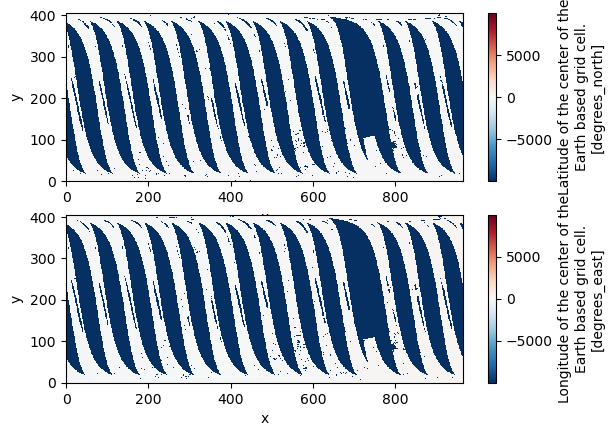

In [6]:
fig, ax = plt.subplots(2, 1)
gds.latitude.plot(ax=ax[0])
gds.longitude.plot(ax=ax[1])

This looks a little strange.  Printing minima and maxima for `latitude` and `longitude`, shows that minimum values are outside of the expected ranges: -90 to 90 for `latitude`, and -180 to 180 or 0 to 360 for `longitude`.

In [7]:
print(f"Latitude:  Min = {gds.latitude.min().values}, "
      f"Max = {gds.latitude.max().values}")
print(f"Longitude: Min = {gds.longitude.min().values}, "
      f"Max = {gds.longitude.max().values}")

Latitude:  Min = -9999.0, Max = 83.63197326660156
Longitude: Min = -9999.0, Max = 179.8132781982422


If we plot both latitude and soil_moisture, we can see that latitude values have been masked with -9999. where there are no valid data values.  **This is not a good or sensible approach because latitude and longitude are coordinates.  As long as latitude and longitude values are between -90 and 90, and -180 and 180 (or 0 and 360), they are valid coordinates.  While CF-Conventions allow missing values are allowed for _auxillary coordinates_, we need coordinates for all grid cells for plotting and other operations.** 

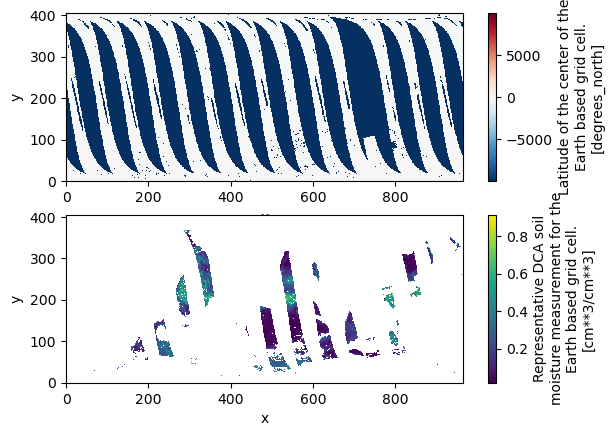

In [8]:
fig, ax = plt.subplots(2, 1)
gds.latitude.plot(ax=ax[0]);
gds.soil_moisture.plot(ax=ax[1])

Neither the plot of latitude nor the minimum and maximum values look as we would expect.  We expect latitude to be in the range of -90 to +90.  The maximum is actually in this range but the minimum is -9999., which is suspiciously like a `_FillValue` or missing data value.  We would also expect the image to show a smooth field that only varies in the vertical direction, e.g. from -90. to 90. or some similar range.  Instead it shows a set of lozenges.

Let's set the `_FillValue` attribute for latitude to `-9999`.  In `xarray`, we have to use `where` to apply a mask everywhere a condition is not `True`.  Here we set the condition to be _not equal to -9999._  To save time and errors later, we also set the `encoding` entry for `fillvalue` to -9999.

<div class="alert alert-block alert-warning">
`encoding` is a dictionary of parameters that defines how data are "encoded" in the file.  It includes information about how data are compressed, chunked, the _FillValue, and data type.  Saving the `encoding` is not strictly necessary unless you want to write the data to a new file.  We'll follow these steps here to demonstrate how to preserve the encoding data. 
</div>

In [9]:
print(gds.latitude.encoding)

{'chunksizes': (1, 964), 'fletcher32': False, 'shuffle': False, 'preferred_chunks': {'phony_dim_0': 1, 'phony_dim_1': 964}, 'zlib': True, 'complevel': 2, 'source': '/home/apbarret/src/NSIDC-Data-Tutorials/notebooks/SMAP/smap_data/SMAP_L3_SM_P_20170301_R19240_001.h5', 'original_shape': (406, 964), 'dtype': dtype('<f4')}


In [10]:
fillvalue = -9999.

# `where` does not preserve encoding, so we have to copy first
encoding = gds.latitude.encoding
# Apply fillvalue mask
gds['latitude'] = gds.latitude.where(gds.latitude != fillvalue)
# we copy the encoding back to DataArray
gds.latitude.encoding = encoding
# ...and update encoding to include fillvalue
gds.latitude.encoding['fillvalue'] = fillvalue

# ...and for longitude
encoding = gds.longitude.encoding
gds["longitude"] = gds.longitude.where(gds.longitude != fillvalue)
gds.longitude.encoding = encoding
gds.longitude.encoding["fillvalue"] = fillvalue
                                       

Now when we check the range of the latitude values, we see that the range is between -83.63... and 83.63... as we expect.

In [11]:
print(f"Latitude:  Min = {gds.latitude.min().values}, Max = {gds.latitude.max().values}")
print(f"Longitude: Min = {gds.longitude.min().values}, Max = {gds.longitude.max().values}")

Latitude:  Min = -83.63197326660156, Max = 83.63197326660156
Longitude: Min = -179.8132781982422, Max = 179.8132781982422


Plotting the data again, we see that latitude values are within the expected range but that hasn't solved the missing data problem.

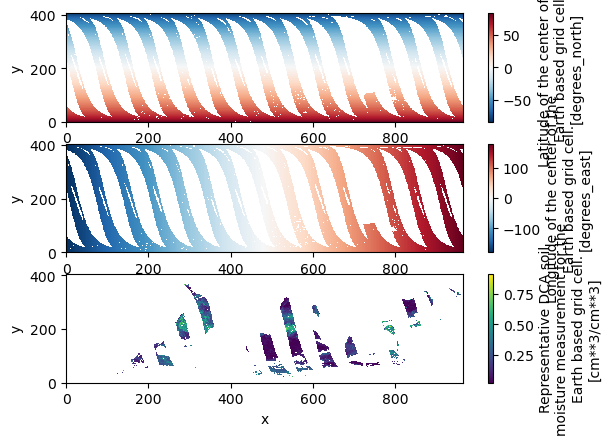

In [12]:
fig, ax = plt.subplots(3, 1)
gds.latitude.plot(ax=ax[0]);
gds.longitude.plot(ax=ax[1]);
gds.soil_moisture.plot(ax=ax[2])

#### Adding x and y coordinates

Missing values for latitude and longitude can cause problems for plotting and other operations.  As noted above, the files do not include complete information about the coordinate reference system or the grid definition.  So we need to do some data sleuthing.

Tables 4 and 5 in the [User Guide](https://nsidc.org/sites/default/files/spl3smp-v008-userguide.pdf) provide geospatial information.  Further information on EASE Grids can be found on [A Guide to EASE Grids page](https://nsidc.org/data/user-resources/help-center/guide-ease-grids).

<div class="alert alert-block alert-warning">
<b>Note:</b> The ATBD for the L3 SMP data gives the data array dimensions as 406 x 963.
</div>



The CRS and grid definition are independent of each other.  The CRS defines how projected coordinates, usually in meters, relate to geographic latitude and longitude.  The grid definition relates how image coordinates (columns and rows) map to the projected coordinates.  The Guide to EASE Grids has 8 grid definitions, ranging from 1 km to 36 km cell sizes, for the Global EASE-Grid 2.0 CRS (EPSG:9633).  We could define many more grid definitions.

In the [table](https://nsidc.org/data/user-resources/help-center/guide-ease-grids#anchor-10) for the 36 km Global EASE-Grid 2.0 we are given the height and width of each grid cell, and the x and y coordinates of the upper-left corner of the upper-left grid cell.  We can see that the 36 km grid cell size is not exact.  In fact, even the value the table gives is not precise enough.  The actual value runs to 9 decimal places.  This is because the grid cell height and width of the global grid were defined so that an exact number of cells span the equator {@brodzik_ease}.

<div class="alert alert-block alert-info">
<b>Tip:</b> Exact definitions of CRS, projection and grid parameters can be found in the Grid Parameter Definition (gpd) files in the [`mapxmaps` GitHub repository](https://github.com/nsidc/mapxmaps).  These gpd files have a somewhat esoteric format, so might take a little bit to understand.  It is important that the grid definition is exact because we cannot merge datasets if the coordinates do not match, even to the 9th decimal place.
</div>

The relevant gpd file for the SMAP data is `EASE2_M36km.gpd`, which we show here.

```
; 36 km Global EASE-Grid-2.0 grid parameter definition.
; This projection uses the WGS84 ellipsoid.
; The left and right edges of the grid are at -+180.0000000 deg longitude.
; The top and bottom edges of the grid are at  +-85.0445664 deg latitude.
Map Projection:                     Cylindrical Equal-Area (ellipsoid)
Map Reference Latitude:             0.0
Map Reference Longitude:            0.0
Map Second Reference Latitude:      30.0
Map Rotation:                       0.0
Map Equatorial Radius:              6378137.0         ; wgs84
Map Eccentricity:                   0.081819190843    ; wgs84
Map Origin X:                       -17367530.4451615 ; meters, -180.0000 deg lon
                                                      ; mapped to X
Map Origin Y:                       7314540.8306386   ; meters, Grid Map Units
                                                      ; per Cell *
                                                      ; Grid Height / 2
Grid Map Origin Column:             -0.5
Grid Map Origin Row:                -0.5
Grid Map Units per Cell:            36032.220840584   ; meters, -2 * Map Origin X
                                                      : / Grid Width
Grid Width:                         964
Grid Height:                        406               
```

The grid cell width and height is given by `Grid Map Units per Cell`.  The `x` and `y` coordinates for the grid is given by `Map Origin X` and `Map Origin Y`.

In [13]:
grid_cell_width = 36032.220840584
grid_cell_height = -36032.220840584
x_upper_left_corner = -17367530.4451615
y_upper_left_corner = 7314540.8306386

The projected coordinates of a grid cell can be found using the following formulas:

$$
x = (grid\_cell\_width \times row) + x\_upper\_left\_corner
$$
$$
y = (grid\_cell\_height \times column) + y\_upper\_left\_corner)
$$

This equations assumes that the origin of the image coordinates start at row=0. and column=0. in the upper-left corner of the upper-left grid cell.  So the center of the upper-left grid cell is row=0.5 and column=0.5.  Adding 0.5 to row and column indices solves this problem.

We could write a function to return (x, y) coordinates for (column, row) image coordinates using the equations above.  Or we can use the `Affine` class from the `affine` package to define an affine matrix.  This is what we'll do below.  

In [14]:
transform = Affine(grid_cell_width, 0.0, x_upper_left_corner, 
                   0.0, grid_cell_height, y_upper_left_corner)
transform

Affine(36032.220840584, 0.0, -17367530.4451615,
       0.0, -36032.220840584, 7314540.8306386)

This then allows us to calculate x and y coordinates from column and row indices using matrix multiplication.

In [15]:
transform * (964, 406)

(17367530.445161477, -7314540.830638505)

We'll define vectors for the row and column indices of the grid cell centers, and then use the `transform` matrix to get x and y coordinates.  These only need to be vectors as well because each column will have the same row indices and each row will have the same column indices. We'll use the `numpy.arange` function to generate row and columns, and start the range at 0.5 to offset these indices for grid cell centers by 0.5.  The `_` used here is a Pythonic way to have a _Throwaway value_.

In [16]:
nrows, ncolumns, nclass = gds.sizes['y'], gds.sizes['x'], gds.sizes['igbp_class']
row = np.arange(0.5, nrows)
column = np.arange(0.5, ncolumns)

x, _ = transform * (column, 0.5)
_, y = transform * (0.5, row)
igbp_class = np.arange(nclass)  # Add attributes

We create `x`, `y`, and `igbp_class` coordinates as `xarray.DataArrays`.  Before we assign coordinates to the `Dataset`, we will add some attributes to these _coordinate variables_.  Under CF-Conventions, _Coordinate variables_ should have _units_, _long_name_, and _standard_name_ attributes.  

In [17]:
x_da = xr.DataArray(
    x, 
    dims=['x'], 
    attrs={
        "units": "m",
        "long_name": "x coordinate of projection",
        "standard_name": "projection_x_coordinate",
    }
)

y_da = xr.DataArray(
    y, 
    dims=['y'], 
    attrs={
        "units": "m",
        "long_name": "y coordinate of projection",
        "standard_name": "projection_y_coordinate",
    }
)

igbp_da = xr.DataArray(
    igbp_class,
    dims=['igbp_class'],
    attrs={
        "long_name": "index for IGBP land cover type",
    }
)

We then use `assign_coords` to assign coordinate variables to the dataset.

In [18]:
gds = gds.assign_coords(x=x_da, y=y_da, igbp_class=igbp_da)
gds

<xarray.Dataset> Size: 99MB
Dimensions:                      (y: 406, x: 964, igbp_class: 3)
Coordinates:
  * x                            (x) float64 8kB -1.735e+07 ... 1.735e+07
  * y                            (y) float64 3kB 7.297e+06 ... -7.297e+06
  * igbp_class                   (igbp_class) int64 24B 0 1 2
Data variables: (12/53)
    EASE_column_index            (y, x) float32 2MB ...
    EASE_row_index               (y, x) float32 2MB ...
    albedo                       (y, x) float32 2MB ...
    albedo_dca                   (y, x) float32 2MB ...
    albedo_scah                  (y, x) float32 2MB ...
    albedo_scav                  (y, x) float32 2MB ...
    ...                           ...
    tb_v_uncorrected             (y, x) float32 2MB ...
    vegetation_opacity           (y, x) float32 2MB ...
    vegetation_opacity_dca       (y, x) float32 2MB ...
    vegetation_opacity_scah      (y, x) float32 2MB ...
    vegetation_opacity_scav      (y, x) float32 2MB ...
    vegetation_water_content     (y, x) float32 2MB ...

In addition to assigning coordinates, we need to provide information about the CRS that relates these coordinates to the Earth.  We use the `rioxarray` accessor methods to do this.  Using these methods ensures that information is written in the correct format to the correct place in the file.

The `rio.write_crs` accepts an EPSG code.  We also assign a `grid_mapping_name`, which creates a _grid mapping variable_.  While not strictly necessary because the `x` and `y` coordinates are included, we add the `transform` for completeness.

In [19]:
gds.rio.write_crs(6933, grid_mapping_name='wgs84_easegrid2_global', inplace=True)
gds.rio.set_spatial_dims(x_dim='x', y_dim='y', inplace=True)
gds.rio.write_coordinate_system(inplace=True)
gds.rio.write_transform(transform)
gds.rio.write_grid_mapping('wgs84_easegrid2_global', inplace=True)
gds

<xarray.Dataset> Size: 99MB
Dimensions:                      (y: 406, x: 964, igbp_class: 3)
Coordinates:
  * x                            (x) float64 8kB -1.735e+07 ... 1.735e+07
  * y                            (y) float64 3kB 7.297e+06 ... -7.297e+06
  * igbp_class                   (igbp_class) int64 24B 0 1 2
    wgs84_easegrid2_global       int64 8B 0
Data variables: (12/53)
    EASE_column_index            (y, x) float32 2MB ...
    EASE_row_index               (y, x) float32 2MB ...
    albedo                       (y, x) float32 2MB ...
    albedo_dca                   (y, x) float32 2MB ...
    albedo_scah                  (y, x) float32 2MB ...
    albedo_scav                  (y, x) float32 2MB ...
    ...                           ...
    tb_v_uncorrected             (y, x) float32 2MB ...
    vegetation_opacity           (y, x) float32 2MB ...
    vegetation_opacity_dca       (y, x) float32 2MB ...
    vegetation_opacity_scah      (y, x) float32 2MB ...
    vegetation_opacity_scav      (y, x) float32 2MB ...
    vegetation_water_content     (y, x) float32 2MB ...

We can see the `grid_mapping_variable` has been added to the `Dataset` as a _coordinate variable_.  A `grid_mapping` has also been added to each variable.  In a netCDF file, this is an attribute.  In `xarray`, `grid_mapping` is added to the encoding for each variable.  We can access this information in the `Dataset`, using the `rio` accessors.

In [20]:
print(gds.latitude.rio.grid_mapping)
print(gds.rio.bounds())

wgs84_easegrid2_global
(-17367530.4451615, -7314540.830638505, 17367530.445161473, 7314540.8306386)


## Plot the data

We can now plot the data on a map using cartopy.

We use `cartopy.crs.epsg` method to define a cartopy projection from the EPSG we just assigned to the dataset.  

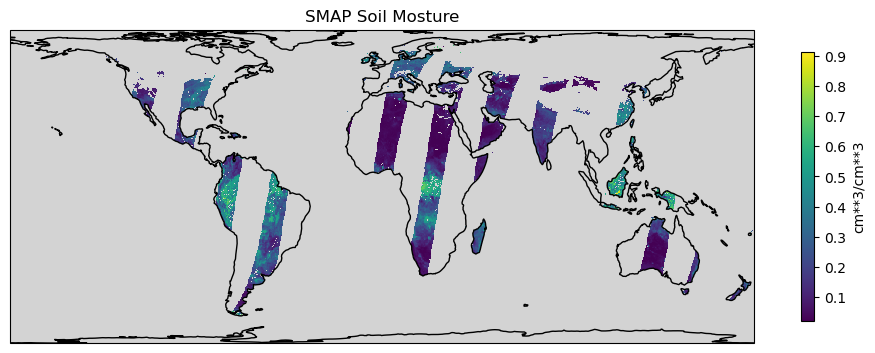

In [21]:
EASEGrid2 = ccrs.epsg(gds.rio.crs.to_epsg())

p = gds.soil_moisture.plot(
    subplot_kws=dict(
        projection=EASEGrid2, 
        facecolor="lightgrey",
    ),
    cbar_kwargs=dict(
        shrink=0.5,
        label=gds.soil_moisture.attrs["units"],
    ),
    figsize=(12,7),
)

p.axes.coastlines()
p.axes.set_title("SMAP Soil Mosture");